In [1]:
import numpy as np



In [12]:
gamma_input = np.random.gamma(0.5,scale=1,size=10000)

(array([7.805e+03, 1.393e+03, 4.800e+02, 1.920e+02, 7.500e+01, 3.100e+01,
        1.000e+01, 8.000e+00, 4.000e+00, 2.000e+00]),
 array([6.21733722e-09, 7.63486862e-01, 1.52697372e+00, 2.29046057e+00,
        3.05394743e+00, 3.81743428e+00, 4.58092114e+00, 5.34440799e+00,
        6.10789485e+00, 6.87138171e+00, 7.63486856e+00]),
 <BarContainer object of 10 artists>)

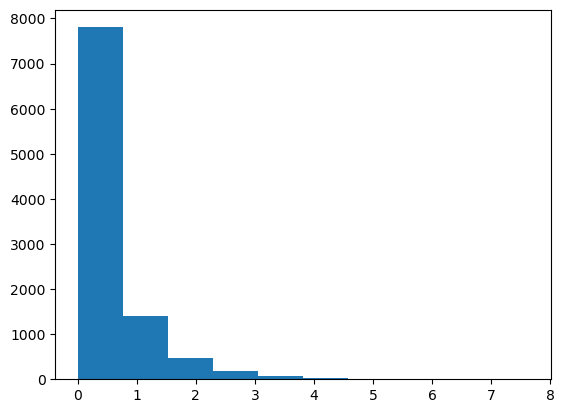

In [13]:
np.histogram(gamma_input)
import matplotlib.pyplot as plt
plt.hist(gamma_input)

In [43]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=2000)

In [44]:
import os 
from ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np
from ipsl_dataset import surface_variables
scratch = os.environ['SCRATCH']
work = os.environ['WORK']



In [45]:
from hydra import compose, initialize
from omegaconf import OmegaConf


with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")

In [46]:
train = IPSL_DCPP('train',cfg.experiment.lead_time_months)
train_dataloader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False,num_workers=1)
batch = next(iter(train_dataloader))

In [47]:
batch['state_surface'].shape

torch.Size([1, 135, 143, 144])

In [48]:
sample_image = batch['state_surface']

In [60]:
from PIL import Image
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([1000])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
noisy_image.shape

torch.Size([1, 135, 143, 144])

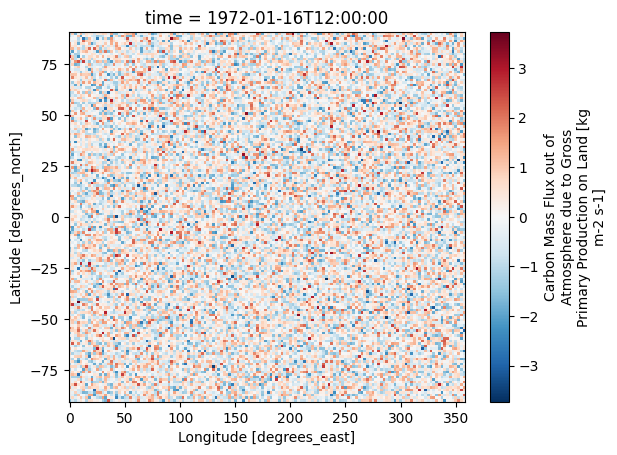

In [61]:
import xarray as xr
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
shell['gpp'].data = noisy_image.squeeze()[14,:,:]
shell['gpp'].plot.pcolormesh()


In [25]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

NameError: name 'model' is not defined

In [23]:
import torch
positional_embeddings = torch.nn.Parameter(torch.zeros((192, 143, 144)))
torch.nn.init.trunc_normal_(positional_embeddings, 0.02)
positional_embeddings

Parameter containing:
tensor([[[-0.6201, -1.6806, -0.5057,  ..., -0.6962,  0.1776, -0.8060],
         [ 0.6451,  1.5150, -1.0916,  ..., -0.4917,  0.8993, -1.1166],
         [-0.2386, -0.0221,  0.8302,  ...,  0.4217,  0.2914, -0.6981],
         ...,
         [ 0.7291, -0.2253,  0.0263,  ...,  1.0868,  0.7530, -0.0228],
         [ 1.6675,  0.5248, -0.8197,  ..., -1.8779, -0.6522, -1.1267],
         [-1.0503, -1.0180,  0.4509,  ..., -0.6547,  1.1838, -0.4919]],

        [[ 0.2637, -0.9106, -1.6740,  ..., -0.1675,  0.1672, -0.0906],
         [-0.6348, -0.2202, -0.9122,  ..., -0.4296,  0.5806,  0.1798],
         [ 0.5205,  0.9444, -0.2046,  ..., -0.5350,  0.7383,  0.2632],
         ...,
         [-0.9219,  1.7390, -0.1604,  ..., -0.8780, -0.9514,  1.5099],
         [-0.0660, -0.8995,  1.7929,  ..., -0.2552,  0.5893, -0.8472],
         [-1.4691, -0.6549, -1.5962,  ..., -0.4189, -1.9393, -1.6961]],

        [[ 1.6447,  1.7556,  0.9082,  ..., -0.6181,  0.9813, -0.3187],
         [ 0.7963, -0.2

In [15]:
embedding_dim = 192
import math
max_period = 10000
timesteps=torch.tensor([1])

In [19]:
half_dim = embedding_dim // 2
exponent = -math.log(max_period) * torch.arange(
    start=0, end=half_dim, dtype=torch.float32, device=timesteps.device
)
exponent = exponent / (half_dim - 1)

emb = torch.exp(exponent)
emb = timesteps[:, None].float() * emb[None, :]

# scale embeddings
emb = 1 * emb

# concat sine and cosine embeddings
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

# flip sine and cosine embeddings

# zero pad
if embedding_dim % 2 == 1:
    emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))


In [29]:
positional_embeddings[None]

tensor([[[[-0.6201, -1.6806, -0.5057,  ..., -0.6962,  0.1776, -0.8060],
          [ 0.6451,  1.5150, -1.0916,  ..., -0.4917,  0.8993, -1.1166],
          [-0.2386, -0.0221,  0.8302,  ...,  0.4217,  0.2914, -0.6981],
          ...,
          [ 0.7291, -0.2253,  0.0263,  ...,  1.0868,  0.7530, -0.0228],
          [ 1.6675,  0.5248, -0.8197,  ..., -1.8779, -0.6522, -1.1267],
          [-1.0503, -1.0180,  0.4509,  ..., -0.6547,  1.1838, -0.4919]],

         [[ 0.2637, -0.9106, -1.6740,  ..., -0.1675,  0.1672, -0.0906],
          [-0.6348, -0.2202, -0.9122,  ..., -0.4296,  0.5806,  0.1798],
          [ 0.5205,  0.9444, -0.2046,  ..., -0.5350,  0.7383,  0.2632],
          ...,
          [-0.9219,  1.7390, -0.1604,  ..., -0.8780, -0.9514,  1.5099],
          [-0.0660, -0.8995,  1.7929,  ..., -0.2552,  0.5893, -0.8472],
          [-1.4691, -0.6549, -1.5962,  ..., -0.4189, -1.9393, -1.6961]],

         [[ 1.6447,  1.7556,  0.9082,  ..., -0.6181,  0.9813, -0.3187],
          [ 0.7963, -0.2555, -